# Semantic change in LatinISE (medical terms)


Barbara McGillivray, Paola Marongiu

This notebook contains the code used for the evaluation of the word embeddings trained on the LatinISE corpus, performed for the Short Term Scientific Mission (STSM) funded by the COST Action “Nexus Linguarum” (CA 18209) and carried out at the King’s College London, under the supervision of Dr. Barbara McGillivray (King’s College London) and Dr. Fahad Khan (CNR-ILC). Grant reference: E-COST-GRANT-CA18209-c61c3227.
The code is from McGillivray, B. & Nowak, K. (2022). Tracing the semantic change of socio-political terms from Classical to early Medieval Latin with computational methods. In Latin vulgaire – latin tardif XIV. 14th International Colloquium on Late and Vulgar Latin. September 5-9, 2022, Ghent University. Book of Abstracts. Ghent University. https://www.lvlt14.ugent.be/wp-content/uploads/2022/09/LVLT14-Book-of-abstracts.pdf (last accessed date: 31/01/2023).

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [55]:
!pip install gensim==4.0
!pip install plotly

Import libraries

In [56]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

ModuleNotFoundError: No module named 'spacy'

# Parameters

I set the parameters of the analysis.

In [57]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [58]:
dir_in = os.path.join("/home", "paola_user", "Scaricati", "LatinISE")
dir_out = os.path.join(dir_in, "semantic_change_output")

I define the list of all files:

In [59]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [60]:
len(files)

1273

We only want IntraText files: (why? because some texts are repeated. add medical texts not in IntraText)

In [61]:
files = [f for f in files if "IT" in f or "CC" in f]
len(files)

675

I read the metadata file:

In [62]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith(("IT", "CC"))] #we want all the files from IT (one medical text is not among IntraText)
metadata_df = metadata_df[metadata_df['date'] < 700] #stop at x year
metadata_df

,id,title,creator,date,type,file,medical text
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,0
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,0
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399,prose,lat_0399_IT-LAT0015.txt,0
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391,prose,lat_0391_IT-LAT0016.txt,0
...,...,...,...,...,...,...,...
1266,CC-082,Etymologiae IV,Isidorus Hispalensis Episcopus,625,prose,CC-082_Isidorus-Hispalensis_Etymologiae-final.txt,1
1267,CC-dlt000079,de medicina,Cassius Felix,447,prose,CC-dlt000079-tagged-final.txt,1
1268,CC-dlt000362,De herba vettonica liber,Antonius Musa,300,prose,CC-dlt000362-tagged-final.txt,1
1269,CC-dlt000412,De medicina,Plinius Secundus Iunior Ps.,300,prose,CC-dlt000412-tagged-final.txt,1


### Number of tokens in the corpus of texts until 700 CE

In [65]:
token_count = 0
for filename in os.listdir(dir_in):
    print(filename)
    for j in metadata_df['id']:
        if j in filename:
            #print(filename, "done")
            with open(os.path.join(dir_in, filename), 'r') as file:
                content = file.read()
                tokens = content.split()
                token_count += len(tokens)
        
        # Output the token count
print(token_count)

distribution-texts.png
works-per-year.png
LatinISE_metadata_med.csv
Semantic_changevariation_analysis.ipynb
.ipynb_checkpoints
latinise_metadata.csv
works-per-year-1000.png
STSM_general.ipynb
Final_STSM_medical_latin.ipynb
raw
med-non-med-hist.png
old_STSM_medical_latin.ipynb
semantic_change_output
logfile.txt
preprocessed_tokens
preprocessed_lemmas
LatinISE_corrections
Metadata_selected_corpus.csv
latinise_metadata_corrected.xlsx
evaluation
quantitative_STSM_medical_latin.ipynb
medical words.csv
Latinise-Wiki_corrected.tsv
0


Metadata about medical texts 

In [66]:
med_metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
med_metadata_df = med_metadata_df[med_metadata_df['id'].str.startswith(("IT", "CC"))] #we want all the files from IT (one medical text is not among IntraText)
med_metadata_df = med_metadata_df[med_metadata_df['date'] < 700]
med_metadata_df = med_metadata_df[med_metadata_df['medical text'] == 1]
med_metadata_df

,id,title,creator,date,type,file,medical text
221,IT-LAT0382,De medicina,"Celsus, Cornelius Aulus",30,prose,lat_0030_IT-LAT0382.txt,1
562,IT-LAT0895,Medicina ex oleribus et pomis,"Gargilius Martialis, Quintus",260,prose,lat_0260_IT-LAT0895.txt,1
634,IT-LAT0987,De observatione ciborum,Anthimus,550,prose,lat_0550_IT-LAT0987.txt,1
837,IT-MQDQ-247,medicamina faciei,"Ovidius Naso, Publius",30,poetry,lat_+0030_MQDQ-247.txt,1
1221,IT-MQDQ-440,liber medicinalis,quintus serenus,350,poetry,lat_0350.0_MQDQ-440.txt,1
1266,CC-082,Etymologiae IV,Isidorus Hispalensis Episcopus,625,prose,CC-082_Isidorus-Hispalensis_Etymologiae-final.txt,1
1267,CC-dlt000079,de medicina,Cassius Felix,447,prose,CC-dlt000079-tagged-final.txt,1
1268,CC-dlt000362,De herba vettonica liber,Antonius Musa,300,prose,CC-dlt000362-tagged-final.txt,1
1269,CC-dlt000412,De medicina,Plinius Secundus Iunior Ps.,300,prose,CC-dlt000412-tagged-final.txt,1
1270,CC-Plinius-maior,Naturalis historia,Plinius maior,79,prose,CC-Plinius-maior_Naturalis-historia-tagged-fin...,1


### Number of tokens in medical texts

In [67]:
token_count = 0
for filename in os.listdir(folder_path):
    #print(filename)
    for j in med_metadata_df['id']:
        if j in filename:
            print(filename, "done")
            with open(os.path.join(folder_path, filename), 'r') as file:
                content = file.read()
                tokens = content.split()
                token_count += len(tokens)
        
        # Output the token count
print(token_count)

NameError: name 'folder_path' is not defined

Number of tokens in each medical text

In [14]:
token_count = 0
for filename in os.listdir(folder_path):
    #print(filename)
    for j in med_metadata_df['id']:
        if j in filename:
            # Get the title corresponding to the 'id'
            title = med_metadata_df[med_metadata_df['id'] == j]['title'].values[0]
            author = med_metadata_df[med_metadata_df['id'] == j]['creator'].values[0]

            print(f"Filename: {filename}, Title: {title}, Author: {author}, done")
            with open(os.path.join(folder_path, filename), 'r') as file:
                for f in file:
                    content = file.read()
                    tokens = content.split()
                    token_count = len(tokens)
                    print(token_count)

NameError: name 'folder_path' is not defined

Metadata about NON medical texts

In [15]:
non_med_metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
non_med_metadata_df = non_med_metadata_df[non_med_metadata_df['id'].str.startswith(("IT", "CC"))] #we want all the files from IT (one medical text is not among IntraText)
non_med_metadata_df = non_med_metadata_df[non_med_metadata_df['date'] < 700]
non_med_metadata_df = non_med_metadata_df[non_med_metadata_df['medical text'] == 0]
non_med_metadata_df

,id,title,creator,date,type,file,medical text
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,0
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,0
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399,prose,lat_0399_IT-LAT0015.txt,0
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391,prose,lat_0391_IT-LAT0016.txt,0
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,0
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,0
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0


### Number of tokens in non medical texts

Count n. tokens in non medical texts

In [16]:
token_count = 0
for filename in os.listdir(folder_path):
    print(filename)
    for j in non_med_metadata_df['id']:
        if j in filename:
            print(filename, "done")
            with open(os.path.join(folder_path, filename), 'r') as file:
                content = file.read()
                tokens = content.split()
                token_count += len(tokens)
        
        # Output the token count
print(token_count)

NameError: name 'folder_path' is not defined

In [17]:
metadata_df.shape

(362, 7)

In [18]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type', 'file', 'medical text'], dtype='object')

In [19]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
23      399
24      391
       ... 
1266    625
1267    447
1268    300
1269    300
1270     79
Name: date, Length: 362, dtype: int64>

In [20]:
metadata_df.dtypes

id              object
title           object
creator         object
date             int64
type            object
file            object
medical text     int64
dtype: object

Convert date to integer

In [21]:
metadata_df['date'] = metadata_df['date'].astype(int)
metadata_df.dtypes

id              object
title           object
creator         object
date             int64
type            object
file            object
medical text     int64
dtype: object

In [22]:
metadata_df.head

<bound method NDFrame.head of                     id                     title  \
18          IT-LAT0001                   Vulgata   
19          IT-LAT0537              Ars amatoria   
20          IT-LAT0011       S. Benedicti Regula   
23          IT-LAT0015              Confessiones   
24          IT-LAT0016                    Regula   
...                ...                       ...   
1266            CC-082            Etymologiae IV   
1267      CC-dlt000079               de medicina   
1268      CC-dlt000362  De herba vettonica liber   
1269      CC-dlt000412               De medicina   
1270  CC-Plinius-maior        Naturalis historia   

                             creator  date    type  \
18                        Hieronymus   382  poetry   
19             Ovidius Naso, Publius    -9  poetry   
20              Benedictus Nursianus   524   prose   
23              Augustinus, Aurelius   399   prose   
24              Augustinus, Aurelius   391   prose   
...                  

Number of works per year:

In [23]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 550    21
 562     2
 598     3
 625     1
 650     2
Name: id, Length: 98, dtype: int64

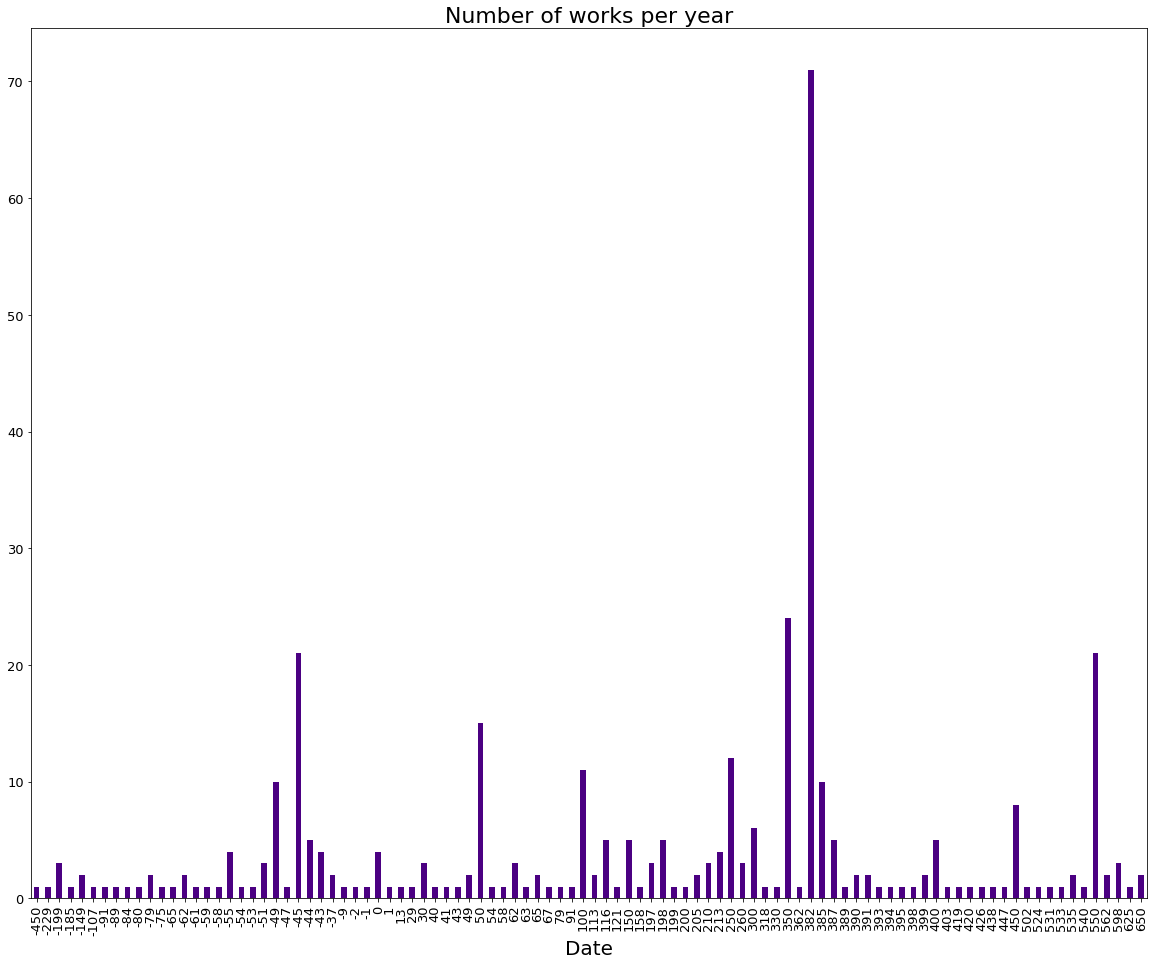

In [34]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=13);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.xlabel("Date", fontsize= 20)
plt.show()

## Split the corpus into subcorpora (medical vs. non medical)

Number of works in medical texts

In [36]:
metadata_df['medical text'] = metadata_df['medical text'].replace({0: 'not medical', 1: 'medical'})
metadata_df1 = metadata_df.groupby(['medical text']).count()
metadata_df1 = metadata_df1['id']
metadata_df1

medical text
medical         10
not medical    352
Name: id, dtype: int64

Visualise in a barplot

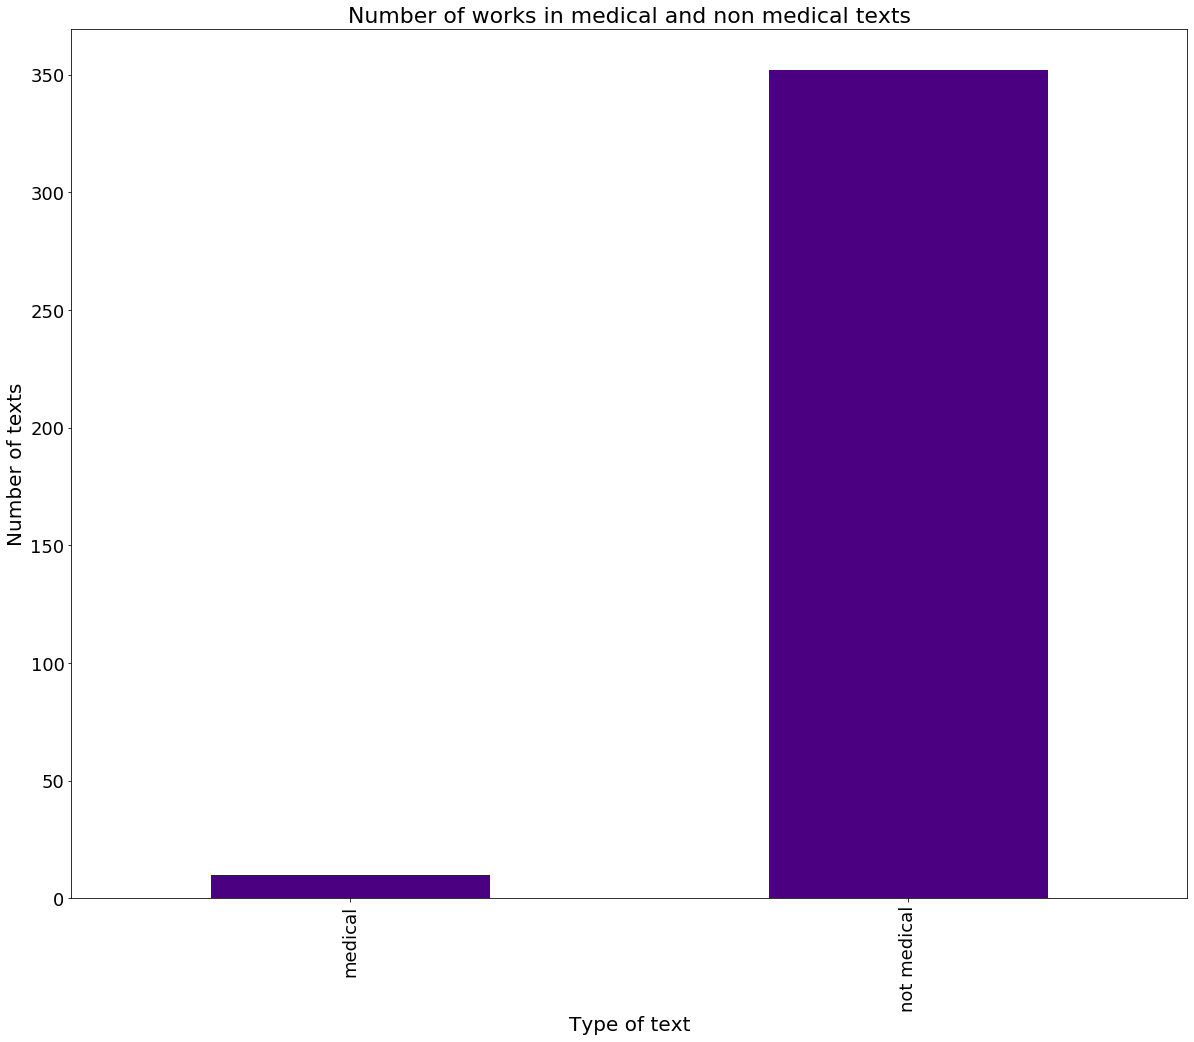

In [29]:

ax = metadata_df1.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=18);
#ax.set_alpha(0.5)
ax.set_title("Number of works in medical and non medical texts", fontsize=22)
plt.ylabel("Number of texts", fontsize= 20)
plt.xlabel("Type of text", fontsize= 20)
plt.show()

Medical and non medical texts

In [68]:
n_subcorpus = metadata_df1
n_subcorpus

medical text
medical         10
not medical    352
Name: id, dtype: int64

In [69]:
len(n_subcorpus)

2

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [27]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [43]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [44]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [45]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

3: lat_0382_IT-LAT0001.txt
3: lat_-009_IT-LAT0537.txt
3: lat_0524_IT-LAT0011.txt
3: lat_0399_IT-LAT0015.txt
3: lat_0391_IT-LAT0016.txt
3: lat_-0049_IT-LAT0029.txt
3: lat_0158_IT-LAT0043.txt
3: lat_0049_IT-LAT0045.txt
3: lat_-0045_IT-LAT0047.txt
3: lat_0050_IT-LAT0051.txt
3: lat_0121_IT-LAT0054.txt
3: lat_-0049_IT-LAT0056.txt
3: lat_0199_IT-LAT0058.txt
3: lat_0387_IT-LAT0061.txt
3: lat_0197_IT-LAT0062.txt
3: lat_0050_IT-LAT0563.txt
3: lat_0062_IT-LAT0071.txt
3: lat_0049_IT-LAT0072.txt
3: lat_0063_IT-LAT0073.txt
3: lat_0000_IT-LAT0075.txt
3: lat_0062_IT-LAT0078.txt
3: lat_0058_IT-LAT0079.txt
3: lat_0385_IT-LAT0574.txt
3: lat_0040_IT-LAT0083.txt
3: lat_0385_IT-LAT0574_1.txt
3: lat_0385_IT-LAT0574_2.txt
3: lat_-0080_IT-LAT0093.txt
3: lat_-0079_IT-LAT0094.txt
3: lat_-0061_IT-LAT0095.txt
3: lat_-0051_IT-LAT0096.txt
3: lat_-0043_IT-LAT0097.txt
3: lat_-0043_IT-LAT0098.txt
3: lat_0385_IT-LAT0574_3.txt
3: lat_-0043_IT-LAT0101.txt
3: lat_0000_IT-LAT0102.txt
3: lat_0385_IT-LAT0574_4.txt
3: lat_-00

3: lat_0250_IT-LAT0959.txt
3: lat_0350_IT-LAT0978.txt
3: lat_0550_IT-LAT0987.txt
3: lat_-0149_IT-LAT0988.txt
3: lat_0550_IT-LAT0990_9.txt
3: lat_-0107_IT-LAT0992.txt
3: lat_-0037_IT-LAT0996.txt
3: lat_-0037_IT-LAT0997.txt
3: lat_0450_IT-LAT1001.txt
3: lat_0395_IT-LAT1004.txt
3: lat_-0229_IT-LAT1006.txt
3: lat_0382_IT-LAT0001_41.txt
3: lat_0382_IT-LAT0001_42.txt
3: lat_0382_IT-LAT0001_43.txt
3: lat_0382_IT-LAT0001_44.txt
3: lat_0382_IT-LAT0001_45.txt
3: lat_0382_IT-LAT0001_46.txt
3: lat_0382_IT-LAT0001_47.txt
3: lat_0382_IT-LAT0001_48.txt
3: lat_0382_IT-LAT0001_49.txt
3: lat_0382_IT-LAT0001_50.txt
3: lat_0382_IT-LAT0001_51.txt
3: lat_0382_IT-LAT0001_52.txt
3: lat_0382_IT-LAT0001_53.txt
3: lat_0382_IT-LAT0001_54.txt
3: lat_0382_IT-LAT0001_55.txt
3: lat_0382_IT-LAT0001_56.txt
3: lat_0382_IT-LAT0001_57.txt
3: lat_0382_IT-LAT0001_58.txt
3: lat_0382_IT-LAT0001_59.txt
3: lat_0382_IT-LAT0001_60.txt
3: lat_0382_IT-LAT0001_61.txt
3: lat_0382_IT-LAT0001_62.txt
3: lat_0382_IT-LAT0001_63.txt
3: lat

FileNotFoundError: [Errno 2] No such file or directory: '/home/paola_user/Scaricati/LatinISE/preprocessed_lemmas/lat_0030_IT-MQDQ-247.txt'

In [46]:
metadata_df

,id,title,creator,date,type,file,medical text
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,not medical
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,not medical
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,not medical
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399,prose,lat_0399_IT-LAT0015.txt,not medical
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391,prose,lat_0391_IT-LAT0016.txt,not medical
...,...,...,...,...,...,...,...
1266,CC-082,Etymologiae IV,Isidorus Hispalensis Episcopus,625,prose,CC-082_Isidorus-Hispalensis_Etymologiae-final.txt,medical
1267,CC-dlt000079,de medicina,Cassius Felix,447,prose,CC-dlt000079-tagged-final.txt,medical
1268,CC-dlt000362,De herba vettonica liber,Antonius Musa,300,prose,CC-dlt000362-tagged-final.txt,medical
1269,CC-dlt000412,De medicina,Plinius Secundus Iunior Ps.,300,prose,CC-dlt000412-tagged-final.txt,medical


In [47]:
corpus

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

In [48]:
len(corpus)

302488

Function for training FastText models (from Krzysztof Nowak):

In [49]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [ ]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=5, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

## Test with "causa" on the whole corpus (both a general term and specialised term in medical Latin)

#### First test: Minimal frequency = 5 (check for lower frequency words) and vector size = 100

Let's see what words are similar to "causa":

In [433]:
model.wv.similar_by_word('causa', 10)

[('causo', 0.8597825169563293),
 ('caussa', 0.850441575050354),
 ('causatio', 0.8314430713653564),
 ('causor', 0.8070116639137268),
 ('causalis', 0.7908177971839905),
 ('causarius', 0.7468041777610779),
 ('musa', 0.7447615265846252),
 ('Susa', 0.7406110763549805),
 ('causaque', 0.7360667586326599),
 ('causamque', 0.722400426864624)]

#### Test 2: Adding max_n=0 and min_n=0 to avoid selection at the string level (turn off subwords), keep the other parameters steady

In [90]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n = 0, min_n = 0)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(21226940, 26628620)

Try again with "causa": results are better. The direct synonym of "causa" in the gold standard Sprugnoli et al. 2020 is "ratio", which still does not appear here

In [91]:
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('potio', 10)

It has taken 99 seconds


[('potus', 0.7746923565864563),
 ('cibus', 0.7582693099975586),
 ('alimentum', 0.6682046055793762),
 ('extenuo', 0.6668452024459839),
 ('concoquo', 0.6660478711128235),
 ('medicamentum', 0.658385157585144),
 ('sitis', 0.6566506028175354),
 ('esca', 0.6549215912818909),
 ('febrem', 0.6542739272117615),
 ('pabulum', 0.6541865468025208)]

#### Test 3: Turn off subwords, raise minimal frequency to 50, vector size 100

In [92]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=50, workers=1, seed=1, hashfxn=hash, max_n = 0, min_n = 0)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(19500429, 26628620)

Try again with "causa"

In [93]:
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('potio', 10)

It has taken 70 seconds


[('cibus', 0.7652978301048279),
 ('esca', 0.713490903377533),
 ('potus', 0.7071375846862793),
 ('sitis', 0.6719212532043457),
 ('incresco', 0.666099488735199),
 ('alimentum', 0.6642388701438904),
 ('stomachus', 0.6602162718772888),
 ('sitio', 0.6561112999916077),
 ('alvus', 0.6513990163803101),
 ('frigidus', 0.6403871774673462)]

I experiment with two equivalent ways to train a Fast Text model:

In [41]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(33210810, 44714280)

In [103]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

523039

In [ ]:
np.allclose(model.wv['dies'], model2.wv['dies'])

The model has a vocabulary of

In [ ]:
model.corpus_total_words

words and 

In [ ]:
model.corpus_count

sentences.

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each subcorpus


For each subcorpus (medical and non medical texts), I read the texts from files and create a list of lists, i.e. a list of sentences:

In [70]:
# dictionary that maps a subcorpus with the list of sentences of texts in that subcorpus"
subcorpus2corpus = dict()
subcorpus = [0, 1]

# I loop over both subcorpora (medical and non medical):
for s in range(len(subcorpus)):
    print('domain:', subcorpus[s])
    files_corpus_s = metadata_df.loc[metadata_df['medical text'] == subcorpus[s]]
    print(files_corpus_s)
    #print("1:",files_corpus_s, type(files_corpus_s))
    corpus_s = list()
    for index, df_line in files_corpus_s.iterrows():
        print("line:", df_line['id'], df_line['medical text'])
        count = 0
        for filename in files:
            count = count + 1
            if df_line['id']+'.txt' in filename and df_line['medical text'] == subcorpus[s]:# and count<10:
                print(df_line['medical text'], "file!", filename)
                file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, filename), 'r')
                sentences_this_file = list()
                while True:
                    line = file.readline().strip()
                    #print(line[1:50])
                    if line != "":
                        corpus_s.append([token for token in line.split(" ") if token not in punctuation])
                    if not line:
                        break
                file.close()
    subcorpus2corpus[s] = corpus_s
   #     sign = "+"
        #print(df_line['date'])
   #     if df_line['date'] < 0:
   #         sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
   #     file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
   #     file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
   #     sentences_this_file = list()
   #     while True:
   #         line = file.readline().strip()
   #         if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
   #             corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
   #         if not line:
   #             break
   #     file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
   # time2corpus[t] = corpus_t


domain: 0
                id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
23      IT-LAT0015                   Confessiones   
24      IT-LAT0016                         Regula   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
23                                 Augustinus, Aurelius   399

line: IT-LAT0278 0
0 file! lat_0013_IT-LAT0278.txt
line: IT-LAT0284 0
0 file! lat_-0049_IT-LAT0284.txt
line: IT-LAT0285 0
0 file! lat_-0450_IT-LAT0285.txt
line: IT-LAT0286 0
0 file! lat_0350_IT-LAT0286.txt
line: IT-LAT0922_14 0
0 file! lat_-0045_IT-LAT0922_14.txt
line: IT-LAT0922_15 0
0 file! lat_-0045_IT-LAT0922_15.txt
line: IT-LAT0990 0
0 file! lat_0550_IT-LAT0990.txt
line: IT-LAT0315 0
0 file! lat_0387_IT-LAT0315.txt
line: IT-LAT0316 0
0 file! lat_0394_IT-LAT0316.txt
line: IT-LAT0317 0
0 file! lat_0387_IT-LAT0317.txt
line: IT-LAT0318 0
0 file! lat_0387_IT-LAT0318.txt
line: IT-LAT0319 0
0 file! lat_0387_IT-LAT0319.txt
line: IT-LAT0320 0
0 file! lat_-0044_IT-LAT0320.txt
line: IT-LAT0325 0
0 file! lat_0050_IT-LAT0325.txt
line: IT-LAT0329 0
0 file! lat_0400_IT-LAT0329.txt
line: IT-LAT0332 0
0 file! lat_0091_IT-LAT0332.txt
line: IT-LAT0333 0
0 file! lat_0450_IT-LAT0333.txt
line: IT-LAT0334 0
0 file! lat_0450_IT-LAT0334.txt
line: IT-LAT0336 0
0 file! lat_0450_IT-LAT0336.txt
line: IT-LAT03

line: IT-LAT0868 0
0 file! lat_0050_IT-LAT0868.txt
line: IT-LAT0873 0
0 file! lat_0300_IT-LAT0873.txt
line: IT-LAT0875 0
0 file! lat_0550_IT-LAT0875.txt
line: IT-LAT0878 0
0 file! lat_0400_IT-LAT0878.txt
line: IT-LAT0880 0
0 file! lat_0400_IT-LAT0880.txt
line: IT-LAT0883 0
0 file! lat_0030_IT-LAT0883.txt
line: IT-LAT0886 0
0 file! lat_0330_IT-LAT0886.txt
line: IT-LAT0893 0
0 file! lat_0260_IT-LAT0893.txt
line: IT-LAT0896 0
0 file! lat_0260_IT-LAT0896.txt
line: IT-LAT0904 0
0 file! lat_0450_IT-LAT0904.txt
line: IT-LAT0906 0
0 file! lat_0550_IT-LAT0906.txt
line: IT-LAT0908 0
0 file! lat_0598_IT-LAT0908.txt
line: IT-LAT0909 0
0 file! lat_0598_IT-LAT0909.txt
line: IT-LAT0913 0
0 file! lat_0250_IT-LAT0913.txt
line: IT-LAT0914 0
0 file! lat_0250_IT-LAT0914.txt
line: IT-LAT0916 0
0 file! lat_0150_IT-LAT0916.txt
line: IT-LAT0917 0
0 file! lat_0502_IT-LAT0917.txt
line: IT-LAT0919 0
0 file! lat_0350_IT-LAT0919.txt
line: IT-LAT0922_16 0
0 file! lat_-0045_IT-LAT0922_16.txt
line: IT-LAT0934 0
0 fil

In [71]:
print(len(subcorpus2corpus[0]))
print(len(subcorpus2corpus[1]))

299145
5366


Let's inspect the corpus for non specialised language:

In [72]:
subcorpus2corpus[0]

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

And the corpus for specialised medical lexicon:

In [73]:
subcorpus2corpus[1]

[['ut',
  'alimentum',
  'sanus',
  'corpus',
  'agricultura',
  'sic',
  'sanitas',
  'aegrum',
  'medicinus',
  'promitto'],
 ['hic',
  'nusquam',
  'quidem',
  'non',
  'sum',
  'siquidem',
  'etiam',
  'inperitissimae',
  'gens',
  'herba',
  'aliaque',
  'promta',
  'in',
  'auxilium',
  'vulnus',
  'morborumque',
  'nosco'],
 ['verus',
  'tamen',
  'apud',
  'Graecus',
  'aliquantus',
  'magis',
  'quam#4',
  'in',
  'ceterus',
  'natio',
  'excolo',
  'sum',
  'atque',
  'ne#2',
  'apud',
  'hic',
  'quidem',
  'ab',
  'primus',
  'origo',
  'sed',
  'paucus',
  'ante',
  'nos',
  'saeculum'],
 ['ut',
  'pote',
  'cum',
  'vetustus',
  'auctor',
  'Aesculapius',
  'celebro',
  'quis#2',
  'quoniam',
  'adhuc',
  'rudis',
  'et',
  'vulgaris',
  'hic',
  'scientia',
  'paulum',
  'subtilis',
  'excoluit',
  'in',
  'deus',
  'numerus',
  'recipio',
  'sum'],
 ['hic',
  'deinde',
  'duo',
  'filius',
  'Podalirius',
  'et',
  'Machaon',
  'bellum',
  'Troiano',
  'dux',
  'Agamemn

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each subcorpus I train a fasttext model:

Start with the first subcorpus:
Barbara: "The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms)"

Try excluding subwords and setting minimal frequency to 5 (see experiment on embeddings for the full corpus with "causa": ideal combination of parameters is max_n=0, min_n=0, min_count=5

In [537]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, min_n=0, max_n=0)
model.build_vocab(corpus_iterable=subcorpus2corpus[0])
model.train(corpus_iterable=subcorpus2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('causa', 10)

It has taken 64 seconds


[('accusatio', 0.6472148895263672),
 ('defensio', 0.6218545436859131),
 ('ratio', 0.5991116762161255),
 ('deliberatio', 0.59092777967453),
 ('probatio', 0.5870963335037231),
 ('quaestio', 0.5855084657669067),
 ('accusator', 0.5606059432029724),
 ('comparatio', 0.5517025589942932),
 ('lis', 0.5504170656204224),
 ('disceptatio', 0.548149824142456)]

In [538]:
print_vocab(model, 10)

word #0/27813 is et
word #1/27813 is sum
word #2/27813 is in
word #3/27813 is quis#2
word #4/27813 is is
word #5/27813 is non
word #6/27813 is hic
word #7/27813 is ab
word #8/27813 is ut


Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms: with minimal frequency = 50

In [539]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=subcorpus2corpus[0])
model.train(corpus_iterable=subcorpus2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('causa', 10)

It has taken 46 seconds


[('defensio', 0.5699906349182129),
 ('quaestio', 0.5561118125915527),
 ('culpa', 0.553999125957489),
 ('ratio', 0.5522872805595398),
 ('accusatio', 0.5466195344924927),
 ('accusator', 0.545127809047699),
 ('litigator', 0.5239123702049255),
 ('disceptatio', 0.5225502252578735),
 ('controversia', 0.512338399887085),
 ('petitor', 0.5046764612197876)]

### Train one model for each subcorpus
I now train one model for each subcorpus (medical vs. non medical): set minimal frequency 5 and exclude subwords
Maximum size vocabulary: 100000

In [74]:
len(subcorpus2corpus)

2

In [75]:
models = list()
start = time.time()
for s in range(len(subcorpus2corpus)):
    if len(subcorpus2corpus[s])>0:
        print(s)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0, min_n=0, max_final_vocab=100000)  # instantiate
        model.build_vocab(corpus_iterable=subcorpus2corpus[s])
        model.train(corpus_iterable=subcorpus2corpus[s], total_examples=len(subcorpus2corpus[s]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
It has taken 146 seconds, or  2 minutes


Check on the two models

In [87]:
print_vocab(models[0], 10)

word #0/27813 is et
word #1/27813 is sum
word #2/27813 is in
word #3/27813 is quis#2
word #4/27813 is is
word #5/27813 is non
word #6/27813 is hic
word #7/27813 is ab
word #8/27813 is ut


In [88]:
print_vocab(models[1], 20)

word #0/2122 is sum
word #1/2122 is et
word #2/2122 is is
word #3/2122 is in
word #4/2122 is quis#2
word #5/2122 is si
word #6/2122 is ex
word #7/2122 is hic
word #8/2122 is vel
word #9/2122 is non
word #10/2122 is aut
word #11/2122 is quod
word #12/2122 is ut
word #13/2122 is cum
word #14/2122 is ad
word #15/2122 is ab
word #16/2122 is quoque
word #17/2122 is sed
word #18/2122 is etiam


In [77]:
word = "aegrotus"
if word in models[1].wv:
    print(f"'{word}' is in the vocabulary.")
else:
    print(f"'{word}' is NOT in the vocabulary.")

# Print vocabulary
vocab = list(model.wv.index_to_key)
#print("Vocabulary:", vocab)

'aegrotus' is in the vocabulary.


## Check malus

In [35]:
word_vector = models[1].wv.similar_by_word('aegrotus')
print(word_vector)

NameError: name 'models' is not defined

In [80]:
word_vector = models[0].wv.similar_by_word('aegrotus')
print(word_vector)

[('gelicidium', 0.6584291458129883), ('contagium', 0.656026303768158), ('fiscella', 0.6285501718521118), ('pulmonibus', 0.6277519464492798), ('carbonibus', 0.6235288977622986), ('sulfur', 0.6227859854698181), ('refoveo', 0.620528519153595), ('Stygem', 0.6198679208755493), ('semianimis', 0.6186054944992065), ('tessellatim', 0.6136469841003418)]


In [103]:
models[0].wv.similar_by_word('fortitudo', 10)

[('virtus', 0.6580463647842407),
 ('bonitas', 0.6566241979598999),
 ('justitia', 0.6449724435806274),
 ('mansuetudo', 0.6409061551094055),
 ('prudentia', 0.6236634850502014),
 ('gloria', 0.6091148853302002),
 ('tolerantia', 0.6018702387809753),
 ('temperantia', 0.5945045351982117),
 ('patientia', 0.5921273827552795),
 ('uirtute', 0.5911977887153625)]

In [126]:
word_vector = models[0].wv.similar_by_word('causa')
print(word_vector)

[('accusatio', 0.5844283103942871), ('defensio', 0.5608288645744324), ('ratio', 0.5422640442848206), ('deliberatio', 0.5239360928535461), ('quaestio', 0.5191012620925903), ('disceptatio', 0.5127232670783997), ('probatio', 0.5119643211364746), ('litigator', 0.5109283924102783), ('crimen', 0.5072946548461914), ('controversia', 0.5000854730606079)]


##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [55]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    print(common_vocab)
    print(m1)
    print(m2)
    return (common_vocab, m1, m2)

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [56]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    common_vocab, in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


Now I can apply the function to my models:

In [57]:
smart_procrustes_align_gensim(models[1], models[0])

I align all models:

In [58]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

Now the models have been aligned and have the same vocabulary:

In [59]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

0 1870
1 1870


# Semantic variation with cosine similarity

In [60]:
models

Let's define a function that calculates the cosine similarity between the embedding of a word in a macrogenre g and the embedding of the same word in the other macrogenre g1:

In [61]:
def cosine_similarity(word, s, s1, models):
    #(range_intervals, range_intervals_index, reference_interval, reference_interval_index)= find_reference_intervals(reference_step)
    sc = np.nan
    if models[s] != '':
        sc = 1-spatial.distance.cosine(models[s].wv[word], models[s1].wv[word])
    return sc

In [62]:
cosine_similarity("sum", 1, 0, models)

0.3642340302467346

In [63]:
cosine_similarity("sum", 0,1, models)

0.3642340302467346

Now I define a function that, given two macrogenre indices (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two macrogenres, and stores this in the dataframe cosine_similarity_df:

In [64]:
def cosine_similarity_dataframe(subcorpus_index1, subcorpus_index2, models):
    if subcorpus_index1<0 or subcorpus_index1>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    cosine_similarity_df = pd.DataFrame(([w, 
            models[subcorpus_index1].wv.get_vecattr(w, "count"),
            models[subcorpus_index2].wv.get_vecattr(w, "count"),
            cosine_similarity(w,subcorpus_index1, subcorpus_index2, models)  
            ] for w in models[subcorpus_index1].wv.index_to_key), 
        columns = ('Word', "Frequency_g1", "Frequency_g2", 
        'Cosine_similarity(w_g1'',w_g2)'))
    return cosine_similarity_df

In [65]:
cosine_similarity_dataframe(0, 1, models)

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)"
0,et,180166,5832,0.264375
1,sum,158604,2900,0.364234
2,in,109007,2601,0.502029
3,quis#2,99019,2289,0.387498
4,is,85349,1903,0.408999
...,...,...,...,...
1865,perfundi,316,6,0.392934
1866,coierunt,315,6,0.727174
1867,pix,315,6,0.666073
1868,fasceis,315,6,0.598250


Visualise the distribution of the semantic similarity scores with a histogram:

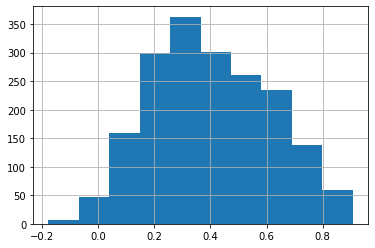

In [66]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
med = cosine_similarity_dataframe(0, 1, models).iloc[:,-1].hist()

Now I can store the full series of the cosine similarity between the embedding of a word in each macrogenre:

In [67]:
series = list()
series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df = cosine_similarity_dataframe(0, 1, models)
series_df[df.columns[0]] = df.iloc[:,0]
series_df[df.columns[1]] = df.iloc[:,1]
series_df[df.columns[2]] = df.iloc[:,2]
series_df[df.columns[3]] = df.iloc[:,3]

#    if i == reference_interval_index:
#        time_series_df = df
#        col_i = "interval-"+str(reference_interval_index)
#        time_series_df[col_i] = [reference_interval_index for w in models[reference_interval_index].wv.index_to_key]
#        col_n = "neighbours_ref-"+reference_step
#        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
#    else:
#        #time_series_df = time_series_df, df.iloc[:,-2:]
#        tmp_df = df.iloc[:,-2:]
#        #df.iloc[:,-2:].column[0]
#        #print(tmp_df.iloc[:,0])
#        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
#        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
#        col_i = "interval-"+str(i)
#        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
#        #Finding top 10 nearest neighbours:
#        col_n = "neighbours_t"+str(i)
#        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
series_df[4] = [models[0].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
series_df[5] = [models[1].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]

#series_df.columns[5] = "neighbours_model1"

series_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",4,5
0,et,180166,5832,0.264375,"[(autem, 0.5418833494186401), (quasi, 0.535878...","[(austerus, 0.9315215945243835), (calidus, 0.9..."
1,sum,158604,2900,0.364234,"[(habeo, 0.5862806439399719), (appareo, 0.5498...","[(corpus, 0.9567714333534241), (ubi, 0.9404152..."
2,in,109007,2601,0.502029,"[(ad, 0.49437129497528076), (circa, 0.47343620...","[(manus, 0.923184335231781), (pono, 0.91932708..."
3,quis#2,99019,2289,0.387498,"[(quod, 0.7463395595550537), (qui, 0.678526043...","[(supra, 0.9537948369979858), (pono, 0.9535297..."
4,is,85349,1903,0.408999,"[(ipse, 0.5668947100639343), (ille, 0.55058604...","[(os#2, 0.9580321311950684), (superus, 0.94116..."
...,...,...,...,...,...,...
1865,perfundi,316,6,0.392934,"[(amomum, 0.5110096335411072), (nardus, 0.4989...","[(prius, 0.9955204129219055), (ieiunus, 0.9923..."
1866,coierunt,315,6,0.727174,"[(bilis, 0.767355740070343), (nigrae, 0.765194...","[(exaspero, 0.9924448132514954), (inde, 0.9922..."
1867,pix,315,6,0.666073,"[(aloe, 0.7731824517250061), (vitellus, 0.7329...","[(XXV, 0.9966520667076111), (lauri, 0.99613171..."
1868,fasceis,315,6,0.598250,"[(mentum, 0.8056813478469849), (candenti, 0.78...","[(aversum, 0.9933187365531921), (venatio, 0.99..."


I rename the last two columns:

In [68]:
't'+str(1)

't1'

In [69]:
series_df.columns=['neighbours_model'+subcorpus[0] if x==4 else x for x in series_df.columns]
series_df.columns=['neighbours_model'+subcorpus[1] if x==5 else x for x in series_df.columns]
series_df

TypeError: can only concatenate str (not "int") to str

In [70]:
series_df.to_csv(os.path.join(dir_out, 'semantic_variation_subcorporamed_allwords.csv'), index=None)

In [71]:
series_df.describe

<bound method NDFrame.describe of           Word  Frequency_g1  Frequency_g2  Cosine_similarity(w_g1,w_g2)  \
0           et        180166          5832                      0.264375   
1          sum        158604          2900                      0.364234   
2           in        109007          2601                      0.502029   
3       quis#2         99019          2289                      0.387498   
4           is         85349          1903                      0.408999   
...        ...           ...           ...                           ...   
1865  perfundi           316             6                      0.392934   
1866  coierunt           315             6                      0.727174   
1867       pix           315             6                      0.666073   
1868   fasceis           315             6                      0.598250   
1869   femoris           315             6                      0.518811   

                                                     

I rearrange the dataframe for visualization:

In [72]:
series_df.columns

Index(['Word', 'Frequency_g1', 'Frequency_g2', 'Cosine_similarity(w_g1,w_g2)',
       4, 5],
      dtype='object')

In [73]:
series_df

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",4,5
0,et,180166,5832,0.264375,"[(autem, 0.5418833494186401), (quasi, 0.535878...","[(austerus, 0.9315215945243835), (calidus, 0.9..."
1,sum,158604,2900,0.364234,"[(habeo, 0.5862806439399719), (appareo, 0.5498...","[(corpus, 0.9567714333534241), (ubi, 0.9404152..."
2,in,109007,2601,0.502029,"[(ad, 0.49437129497528076), (circa, 0.47343620...","[(manus, 0.923184335231781), (pono, 0.91932708..."
3,quis#2,99019,2289,0.387498,"[(quod, 0.7463395595550537), (qui, 0.678526043...","[(supra, 0.9537948369979858), (pono, 0.9535297..."
4,is,85349,1903,0.408999,"[(ipse, 0.5668947100639343), (ille, 0.55058604...","[(os#2, 0.9580321311950684), (superus, 0.94116..."
...,...,...,...,...,...,...
1865,perfundi,316,6,0.392934,"[(amomum, 0.5110096335411072), (nardus, 0.4989...","[(prius, 0.9955204129219055), (ieiunus, 0.9923..."
1866,coierunt,315,6,0.727174,"[(bilis, 0.767355740070343), (nigrae, 0.765194...","[(exaspero, 0.9924448132514954), (inde, 0.9922..."
1867,pix,315,6,0.666073,"[(aloe, 0.7731824517250061), (vitellus, 0.7329...","[(XXV, 0.9966520667076111), (lauri, 0.99613171..."
1868,fasceis,315,6,0.598250,"[(mentum, 0.8056813478469849), (candenti, 0.78...","[(aversum, 0.9933187365531921), (venatio, 0.99..."


List of medical terms:

In [76]:
medical_terms = ["abstinentia", "accidens", "aeger", "aegrotus", "angina", "anus", "aranea", "calvaria", "cancer", "caninus", "caput", "caligo", "carbunculus", "causa", "colis", "caulis", "commotio", "cortex", "elleborosus", "elleborus", "febris", "fistula", "flemina", "folliculus", "fortitudo", "frenum", "gestatio", "gravedo", "imago", "impetus", "insania", "integritas", "iter", "lenticula", "lippitudo", "lumen", "luscitio", "malus", "mappa", "menstrua", "mentagra", "mola", "musculus", "obstetrix", "opstetrix", "panicula", "panucla", "panucula", "panus", "papilla", "patella", "pecten", "pernio", "pituita", "plumbum", "podagra", "pulchritudo", "plaga", "potio", "pupilla", "remedium", "scrotum", "speculum", "spina", "spiritus", "tibia", "tittina", "testis", "tonsilla", "tunicula", "ubuppa", "valetudo", "vitium"]

In [77]:
series_df_med = series_df[series_df['Word'].isin(medical_terms)]
series_df_med.to_csv(os.path.join(dir_out, 'semantic_variation_macrogenres_medwords.csv'), index=None) 
series_df_med

,Word,Frequency_g1,Frequency_g2,"Cosine_similarity(w_g1,w_g2)",4,5
56,causa,9716,281,0.166627,"[(ratio, 0.542263925075531), (res, 0.442950904...","[(ideoque, 0.9894729852676392), (casus, 0.9861..."
165,malus,3748,101,0.360358,"[(malus#3, 0.7656817436218262), (vitium, 0.531...","[(difficultas, 0.9630550742149353), (articulus..."
206,caput,3012,80,0.299397,"[(capitium, 0.5540950894355774), (umerus, 0.53...","[(posterus, 0.9385858774185181), (abstineo, 0...."
209,spiritus,2959,79,0.290143,"[(anima, 0.6076616048812866), (caro, 0.5426247...","[(nam, 0.9927971959114075), (intus, 0.99137240..."
281,iter,2289,64,0.185218,"[(via, 0.6497439742088318), (transitus, 0.5917...","[(redeo, 0.9967816472053528), (exiguus, 0.9962..."
298,vitium,2143,61,0.433223,"[(vitiosus, 0.5695997476577759), (levitas, 0.5...","[(video, 0.9915853142738342), (ferus, 0.984753..."
393,impetus,1664,47,0.297113,"[(concito, 0.5622460246086121), (perrumpo, 0.5...","[(iacio, 0.997539222240448), (inbecillitas, 0...."
487,lumen,1343,37,0.380348,"[(caligo, 0.6976975798606873), (radius, 0.6518...","[(expeditus, 0.9964432120323181), (plerumque, ..."
542,imago,1193,34,0.202409,"[(similitudo, 0.5720979571342468), (figura, 0....","[(via, 0.9955787658691406), (maximus, 0.995324..."
663,plaga,981,27,0.369013,"[(auster, 0.5497010350227356), (subter, 0.5350...","[(crus, 0.9959564208984375), (ibi, 0.994205832..."


In [83]:
models[1].wv.similar_by_word('testis', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Check potio

In [79]:
models[0].wv.similar_by_word('potio', 10)

[('potus', 0.5758991241455078),
 ('cibus', 0.5209862589836121),
 ('alimentum', 0.5165413618087769),
 ('quies', 0.48686540126800537),
 ('vinum', 0.4701482653617859),
 ('egero', 0.468176931142807),
 ('panus', 0.4641687870025635),
 ('medicamentum', 0.4632216989994049),
 ('inedia', 0.44423165917396545),
 ('epotus', 0.4401266872882843)]

In [115]:
models[1].wv.similar_by_word('potio', 10)

[('utor', 0.9829772114753723),
 ('abstineo', 0.9741743803024292),
 ('pridie', 0.9734511971473694),
 ('uti', 0.9712179899215698),
 ('egelidus', 0.9695520401000977),
 ('adsumo', 0.9688200354576111),
 ('acer', 0.9610457420349121),
 ('sumo', 0.9605630040168762),
 ('modicus', 0.9598569869995117),
 ('debeo', 0.9592777490615845)]

## Check lenticula

In [116]:
models[0].wv.similar_by_word('lenticula', 10)

[('unguito', 0.8397071957588196),
 ('porrus', 0.8384392261505127),
 ('anethum', 0.8377937078475952),
 ('acetabulum', 0.8321071863174438),
 ('cepa', 0.8305702805519104),
 ('pipo', 0.8300159573554993),
 ('puleium', 0.8246994614601135),
 ('perna', 0.8239162564277649),
 ('elixabis', 0.8235116600990295),
 ('defritum', 0.8234515190124512)]

In [117]:
models[1].wv.similar_by_word('lenticula', 10)

[('lac', 0.9950354695320129),
 ('ruta', 0.9947835803031921),
 ('olea', 0.99403315782547),
 ('marrubium', 0.9940274357795715),
 ('rubus', 0.9916974902153015),
 ('adjicio', 0.9916856288909912),
 ('sucidus', 0.9906005263328552),
 ('malicorium', 0.9898480772972107),
 ('farina', 0.9896025061607361),
 ('furfur', 0.9895826578140259)]

## Check Impetus

In [119]:
models[0].wv.similar_by_word('impetus', 10)

[('eruptio', 0.681296169757843),
 ('incursus', 0.6700063347816467),
 ('violentia', 0.6155350804328918),
 ('conatus', 0.5932920575141907),
 ('inconsultus', 0.5790584683418274),
 ('vis', 0.5763598680496216),
 ('congressus', 0.5719032883644104),
 ('acriter', 0.5696678757667542),
 ('concursus', 0.5695233941078186),
 ('rabies', 0.5624644756317139)]

In [118]:
models[1].wv.similar_by_word('impetus', 10)

[('scroto', 0.997705340385437),
 ('iacio', 0.9975391626358032),
 ('inbecillitas', 0.9973631501197815),
 ('mature', 0.9973325133323669),
 ('mano', 0.9972262382507324),
 ('numquam', 0.9970070719718933),
 ('aliquando', 0.9968353509902954),
 ('vaco', 0.996812105178833),
 ('muto', 0.9967483878135681),
 ('totus', 0.9967460632324219)]

## Check Plaga

In [52]:
models[0].wv.similar_by_word('plaga', 10)

[('contritio', 0.49932730197906494),
 ('septentrionalis', 0.47354528307914734),
 ('aquilo', 0.4706868827342987),
 ('pessima', 0.4643608033657074),
 ('septentrionem', 0.4558558166027069),
 ('meridies', 0.4414684474468231),
 ('desolo', 0.43876615166664124),
 ('serpens', 0.43028056621551514),
 ('languor', 0.43025338649749756),
 ('sibilo', 0.4296463131904602)]

In [120]:
models[1].wv.similar_by_word('plaga', 10)

[('crus', 0.9959562420845032),
 ('ibi', 0.994205892086029),
 ('scalpellum', 0.9938284158706665),
 ('extendo', 0.9937617182731628),
 ('descendo', 0.9934535622596741),
 ('excidium', 0.993284285068512),
 ('ergo', 0.9932499527931213),
 ('proximus', 0.9931142330169678),
 ('integer', 0.9930745363235474),
 ('iacio', 0.9929271936416626)]

## Check anus

In [121]:
models[0].wv.similar_by_word('anus', 10)

[('cuna', 0.6413418650627136),
 ('formosus', 0.6407531499862671),
 ('genetrix', 0.638460099697113),
 ('vetula', 0.6341239213943481),
 ('procus', 0.6327521800994873),
 ('squalidus', 0.6320462822914124),
 ('lacto', 0.6292959451675415),
 ('mamma', 0.6269815564155579),
 ('virguncula', 0.6218011379241943),
 ('delirus', 0.6181583404541016)]

In [122]:
models[1].wv.similar_by_word('anus', 10)

[('maxilla', 0.9982499480247498),
 ('inguen', 0.9979749917984009),
 ('iuxta', 0.9974749088287354),
 ('ferramentum', 0.9971880912780762),
 ('scrotum', 0.9971383213996887),
 ('antequam', 0.9969991445541382),
 ('vinculum', 0.9969804883003235),
 ('glutino', 0.9967426061630249),
 ('sedeo', 0.9965815544128418),
 ('vulnero', 0.9965251684188843)]

## Check Aranea

In [56]:
models[0].wv.similar_by_word('aranea', 10)

[('pharetra', 0.6134344339370728),
 ('vibro', 0.6050527095794678),
 ('transfigo', 0.6030136346817017),
 ('sulpur', 0.5997458696365356),
 ('hastile', 0.5971342325210571),
 ('texentium', 0.5743292570114136),
 ('stipula', 0.5697602033615112),
 ('ferrum', 0.5689342617988586),
 ('liciatorium', 0.5648847818374634),
 ('spiculus', 0.5626999139785767)]

In [80]:
models[1].wv.similar_by_word('aranea', 10)

[('I', 0.0),
 ('quom', 0.0),
 ('omnesque', 0.0),
 ('fauces', 0.0),
 ('coriandrum', 0.0),
 ('curiosus', 0.0),
 ('proxime', 0.0),
 ('ceno', 0.0),
 ('comprimo', 0.0),
 ('circumcido', 0.0)]

## Check Cancer

In [58]:
models[0].wv.similar_by_word('cancer', 10)

[('aequinoctialis', 0.7350070476531982),
 ('Capricornus', 0.7211254239082336),
 ('lune', 0.7174912691116333),
 ('Chelis', 0.7116904854774475),
 ('exortus', 0.7026336193084717),
 ('Orion', 0.6997062563896179),
 ('Hydrae', 0.696772038936615),
 ('Cancri', 0.6959371566772461),
 ('brumalis', 0.676031231880188),
 ('exoriri', 0.6754188537597656)]

In [59]:
models[1].wv.similar_by_word('cancer', 10)

[('perniciosus', 0.9970979690551758),
 ('muto', 0.9970343112945557),
 ('abscido', 0.9969481825828552),
 ('animal', 0.9968684315681458),
 ('vetustas', 0.9966973066329956),
 ('afficio', 0.9966148734092712),
 ('occupo', 0.9965019226074219),
 ('desum', 0.9964045882225037),
 ('vinculum', 0.9962295889854431),
 ('caelum', 0.9959255456924438)]

## Check Caninus

In [36]:
models[0].wv.similar_by_word('caninus', 10)

[('palo', 0.7080064415931702),
 ('palustrem', 0.7017350196838379),
 ('unctus', 0.6942863464355469),
 ('sucidus', 0.6911542415618896),
 ('pampinus', 0.6911504864692688),
 ('myrteum', 0.6873365044593811),
 ('caedito', 0.686789333820343),
 ('refoveo', 0.686775803565979),
 ('Arsa', 0.6860144138336182),
 ('balsamum', 0.6847855448722839)]

In [124]:
models[1].wv.similar_by_word('caninus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Colis

In [40]:
models[0].wv.similar_by_word('caulis', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

In [126]:
models[1].wv.similar_by_word('colis', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Fistula

In [42]:
models[0].wv.similar_by_word('fistula', 10)

[('vicenum', 0.7571058869361877),
 ('centenum', 0.727862536907196),
 ('modulus', 0.7275359630584717),
 ('diametrum', 0.7077943682670593),
 ('plumbea', 0.7031548023223877),
 ('vicenarius', 0.6905785799026489),
 ('semuncia', 0.6882086992263794),
 ('pertundito', 0.6747350692749023),
 ('crocus', 0.6727489829063416),
 ('quadratus', 0.6727017164230347)]

In [43]:
models[1].wv.similar_by_word('fistula', 10)

[('abscido', 0.9949777722358704),
 ('patefacio', 0.9944912195205688),
 ('membrana', 0.994250476360321),
 ('vinculum', 0.9940910935401917),
 ('cancer', 0.9940453171730042),
 ('rumpo', 0.9939383268356323),
 ('naturalis', 0.9937660694122314),
 ('quicumque', 0.9937065243721008),
 ('talus', 0.9936233758926392),
 ('ala', 0.9935315847396851)]

## Folliculus

In [44]:
models[0].wv.similar_by_word('folliculus', 10)

[('pampinus', 0.8198416829109192),
 ('pineum', 0.8055068850517273),
 ('furfur', 0.8008548617362976),
 ('citrum', 0.796357274055481),
 ('callosus', 0.7912360429763794),
 ('lupinus', 0.7903788089752197),
 ('ficos', 0.787680983543396),
 ('sucidus', 0.7866107821464539),
 ('ulmeus', 0.7819167375564575),
 ('damascena', 0.78098064661026)]

In [127]:
models[1].wv.similar_by_word('folliculus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Lumen

In [46]:
models[0].wv.similar_by_word('lumen', 10)

[('fulgor', 0.7066628932952881),
 ('lux', 0.6773566603660583),
 ('lucidus', 0.6475052237510681),
 ('radius', 0.6295573115348816),
 ('candor', 0.6255735754966736),
 ('caligo', 0.6172627210617065),
 ('luceo', 0.592840313911438),
 ('inlumino', 0.5927273035049438),
 ('splendor', 0.5899431109428406),
 ('caliginem', 0.5879647135734558)]

In [128]:
models[1].wv.similar_by_word('lumen', 10)

[('expeditus', 0.9964432120323181),
 ('plerumque', 0.9961612224578857),
 ('paene', 0.9961373805999756),
 ('restituo', 0.9958831667900085),
 ('curiosus', 0.9958614706993103),
 ('infans', 0.9958545565605164),
 ('capillus', 0.9958263635635376),
 ('adversus', 0.9957664012908936),
 ('prolabor', 0.9956214427947998),
 ('planta', 0.995497465133667)]

## Menstrua

In [49]:
models[0].wv.similar_by_word('menstruus', 10)

[('quintadecima', 0.6784973740577698),
 ('coagulo', 0.6650052070617676),
 ('effluxerit', 0.6644333600997925),
 ('caedito', 0.6587182283401489),
 ('Octobrium', 0.6507802605628967),
 ('seruentur', 0.6498989462852478),
 ('putrescit', 0.6493684649467468),
 ('decembri', 0.6474031805992126),
 ('autumnalis', 0.6436105966567993),
 ('uespera', 0.6390299797058105)]

In [51]:
models[1].wv.similar_by_word('menstruus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Mola

In [52]:
models[0].wv.similar_by_word('mola', 10)

[('plumbum', 0.746660053730011),
 ('aggero', 0.7344804406166077),
 ('cratis', 0.7252821922302246),
 ('bitumen', 0.703269362449646),
 ('crates', 0.7016198635101318),
 ('asinarius', 0.7005409002304077),
 ('funis', 0.6971569061279297),
 ('lamminis', 0.6944992542266846),
 ('condensus', 0.6931260228157043),
 ('coagmento', 0.6929770112037659)]

In [129]:
models[1].wv.similar_by_word('mola', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Musculus

In [54]:
models[0].wv.similar_by_word('musculus', 10)

[('cratis', 0.8192490935325623),
 ('pluteum', 0.7833704352378845),
 ('tabulatus', 0.7824996113777161),
 ('ballista', 0.7676939368247986),
 ('vimen', 0.7657342553138733),
 ('trabes', 0.7561563849449158),
 ('stipites', 0.7425310015678406),
 ('sudibus', 0.7417828440666199),
 ('tignum', 0.7387229800224304),
 ('corium', 0.7376952171325684)]

In [130]:
models[1].wv.similar_by_word('musculus', 10)

[('rumpo', 0.9939658641815186),
 ('incisum', 0.9939491152763367),
 ('exeo', 0.9936187267303467),
 ('subsum', 0.9931867122650146),
 ('decido', 0.993084192276001),
 ('mors', 0.992587685585022),
 ('vitio', 0.9925201535224915),
 ('cucurbitula', 0.9923760294914246),
 ('appareo', 0.9922506809234619),
 ('tumeo', 0.9920444488525391)]

## Patella

In [56]:
models[0].wv.similar_by_word('patella', 10)

[('patina', 0.8819414973258972),
 ('caccabus', 0.8786182999610901),
 ('oenogaro', 0.8742801547050476),
 ('mortarium', 0.8705757260322571),
 ('frico', 0.8621558547019958),
 ('cocta', 0.8574983477592468),
 ('perunges', 0.8552541732788086),
 ('liquamine', 0.8513573408126831),
 ('surclas', 0.8509286642074585),
 ('furnus', 0.8497797250747681)]

In [131]:
models[1].wv.similar_by_word('patella', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Pecten

In [132]:
models[0].wv.similar_by_word('pecten', 10)

[('nemoralis', 0.0),
 ('Mathusalam', 0.0),
 ('ultime', 0.0),
 ('tibus', 0.0),
 ('dispergi', 0.0),
 ('innovata', 0.0),
 ('advertite', 0.0),
 ('Sammai', 0.0),
 ('Ada', 0.0),
 ('Robur', 0.0)]

In [133]:
models[1].wv.similar_by_word('pecten', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Pupilla

In [59]:
models[0].wv.similar_by_word('pupilla', 10)

[('pupillus', 0.6586187481880188),
 ('tutor', 0.6093322038650513),
 ('administrasse', 0.6037088632583618),
 ('tutela', 0.5639089941978455),
 ('obligatus', 0.5460118651390076),
 ('curator', 0.5336513519287109),
 ('patrona', 0.5176621675491333),
 ('vidua', 0.5000547766685486),
 ('pupillaris', 0.4934292137622833),
 ('pignus', 0.48506319522857666)]

In [134]:
models[1].wv.similar_by_word('pupilla', 10)

[('commode', 0.9960851073265076),
 ('protraho', 0.995667040348053),
 ('exaspero', 0.995612621307373),
 ('coicienda', 0.9955204129219055),
 ('specillo', 0.9954385161399841),
 ('inde', 0.995216429233551),
 ('labrum', 0.9949774146080017),
 ('mamma', 0.9946674108505249),
 ('conpremo', 0.9946157932281494),
 ('testa', 0.994404137134552)]

## Scrotum

In [135]:
models[0].wv.similar_by_word('scrotum', 10)

[('nemoralis', 0.0),
 ('Mathusalam', 0.0),
 ('ultime', 0.0),
 ('tibus', 0.0),
 ('dispergi', 0.0),
 ('innovata', 0.0),
 ('advertite', 0.0),
 ('Sammai', 0.0),
 ('Ada', 0.0),
 ('Robur', 0.0)]

In [136]:
models[1].wv.similar_by_word('scrotum', 10)

[('inguen', 0.9977064728736877),
 ('ferramentum', 0.9972655177116394),
 ('anus', 0.9971382021903992),
 ('iuxta', 0.9971233010292053),
 ('maxilla', 0.9968563914299011),
 ('fibula', 0.996627926826477),
 ('glutino', 0.9964139461517334),
 ('talus', 0.9963852167129517),
 ('emineo', 0.9963850378990173),
 ('inguinibus', 0.9963564872741699)]

## Spina

In [137]:
models[0].wv.similar_by_word('spina', 10)

[('tribulus', 0.7177954316139221),
 ('vepres', 0.7168682813644409),
 ('arista', 0.7130506634712219),
 ('testa', 0.6963735818862915),
 ('sentis', 0.6919426321983337),
 ('stramentum', 0.6867840886116028),
 ('virgultum', 0.684074342250824),
 ('vimen', 0.6788965463638306),
 ('urtica', 0.6751440167427063),
 ('palea', 0.6675998568534851)]

In [138]:
models[1].wv.similar_by_word('spina', 10)

[('vertebra', 0.9980313777923584),
 ('retundo', 0.9976984858512878),
 ('uncus', 0.9976956248283386),
 ('sinuo', 0.997674822807312),
 ('apprehendo', 0.9971036911010742),
 ('cerebrum', 0.9969908595085144),
 ('inhaeresco', 0.9969809055328369),
 ('costa', 0.9968867301940918),
 ('rima', 0.9968589544296265),
 ('transversum', 0.9968309998512268)]

## Spiritus

In [68]:
models[0].wv.similar_by_word('spiritus', 10)

[('trinitas', 0.5778629779815674),
 ('angelus', 0.5743215680122375),
 ('Trinitatis', 0.5146111845970154),
 ('diabolus', 0.5006036758422852),
 ('invocatio', 0.4707029163837433),
 ('inspiratio', 0.46047791838645935),
 ('corruptio', 0.4583539068698883),
 ('caro', 0.45777449011802673),
 ('angelicus', 0.45664042234420776),
 ('anima', 0.44951263070106506)]

In [69]:
models[1].wv.similar_by_word('spiritus', 10)

[('nam', 0.9927971959114075),
 ('intus', 0.9913724064826965),
 ('pus', 0.9886324405670166),
 ('frango', 0.9884505271911621),
 ('tumor', 0.9881983995437622),
 ('relinquo', 0.988068163394928),
 ('motus', 0.9880082011222839),
 ('febre', 0.9873912930488586),
 ('nonnumquam', 0.9869715571403503),
 ('intendo', 0.9869352579116821)]

## Tibia

In [140]:
models[0].wv.similar_by_word('tibia', 10)

[('fides#2', 0.8203573822975159),
 ('tympanum', 0.8185532093048096),
 ('chorda', 0.7631313800811768),
 ('cymbalum', 0.7508707642555237),
 ('lyra', 0.7387088537216187),
 ('crepitus', 0.736397385597229),
 ('cithara', 0.7351214289665222),
 ('cantus', 0.7035452723503113),
 ('lituus', 0.7032879590988159),
 ('plectrum', 0.7020777463912964)]

In [139]:
models[1].wv.similar_by_word('tibia', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Vitium

In [72]:
models[0].wv.similar_by_word('vitium', 10)

[('avaritia', 0.6334289312362671),
 ('uitiis', 0.62870192527771),
 ('inertia', 0.6192713379859924),
 ('vitiosus', 0.6179677248001099),
 ('culpa', 0.6062299609184265),
 ('stultitia', 0.6019758582115173),
 ('malitia', 0.5940094590187073),
 ('insolentia', 0.5920464992523193),
 ('neglegentia', 0.5816465616226196),
 ('nequitia', 0.5792486667633057)]

In [73]:
models[1].wv.similar_by_word('vitium', 10)

[('video', 0.9915851354598999),
 ('ferus', 0.9847535490989685),
 ('medicina', 0.9810498952865601),
 ('casus', 0.9806272387504578),
 ('sub', 0.9806148409843445),
 ('autem', 0.9795443415641785),
 ('incido#2', 0.978618860244751),
 ('auxilium', 0.9781866073608398),
 ('orior', 0.9775609374046326),
 ('causa', 0.9765673875808716)]

## Salus

In [142]:
models[0].wv.similar_by_word('salus', 10)

[('incolumitas', 0.6816266775131226),
 ('redemptio', 0.5496746301651001),
 ('utilitas', 0.4986407160758972),
 ('adjutor', 0.48647335171699524),
 ('liberatio', 0.4806784987449646),
 ('redemptor', 0.4782220423221588),
 ('fides', 0.47800642251968384),
 ('commodum', 0.46696460247039795),
 ('libertas', 0.46516478061676025),
 ('conservo', 0.46103864908218384)]

In [141]:
models[1].wv.similar_by_word('salus', 10)

[('tenebrae', 0.9944223761558533),
 ('insanio', 0.994313657283783),
 ('momentum', 0.9940486550331116),
 ('num', 0.9936050772666931),
 ('simplex', 0.9935969114303589),
 ('ordo', 0.9935298562049866),
 ('varietas', 0.9934267401695251),
 ('sapientia', 0.9933403134346008),
 ('expeditus', 0.9933046102523804),
 ('penitus#3', 0.9931431412696838)]